In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential, load_model
from keras import layers
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from keras.callbacks import EarlyStopping
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

In [2]:
if tf.test.is_built_with_cuda():
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())
else: 
    print("CUDA not available")

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13687288643293670288
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4139778048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8324124733094889887
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# сортировка изображений в алфавитном поряддке
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# общий размер для всех изображений
SIZE = 256
high_img = []
# путь к изображениям с высоким разрешением
path = '../../data/image-super-resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # opencv по умолчанию считывает в BGR формате, сразу конвертируем в RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # делаем одинаковый размер
        img = cv2.resize(img, (SIZE, SIZE))
        # нормализуем значения пикселей         
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

low_img = []
# путь к изображениям с низким разрешением и далее все аналогично
path = '../../data/image-super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|███████████████████████████████████████████████████████████████████████████████| 855/855 [00:02<00:00, 419.93it/s]


High:  855 
 Low:  855


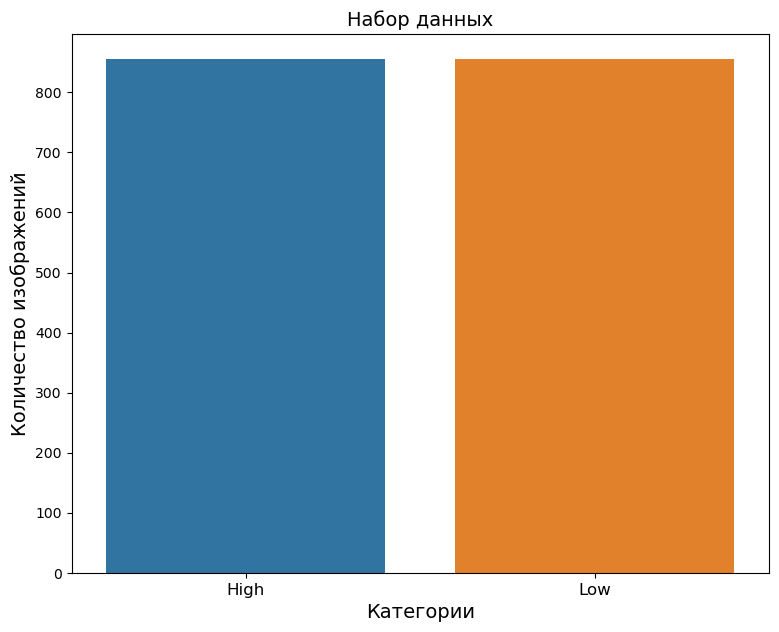

In [4]:
train_data = []

# передаем изображения в список train_data, устанавливаем метки 0 для здоровых и 1 для больных
for img in high_img:
    train_data.append((img,0))

for img in low_img:
    train_data.append((img, 1))
    
# создаем pandas dataframe - двумерный массив из изображений и меток для дальнейшей работы
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

cases_count = train_data['label'].value_counts()
print('High: ', cases_count[0],'\n', 'Low: ', cases_count[1])
# визуализируем 
plt.figure(figsize=(9,7))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Набор данных', fontsize=14)
plt.xlabel('Категории', fontsize=14)
plt.ylabel('Количество изображений', fontsize=14)
plt.xticks(range(len(cases_count.index)), ['High', 'Low'], fontsize=12)
plt.show()

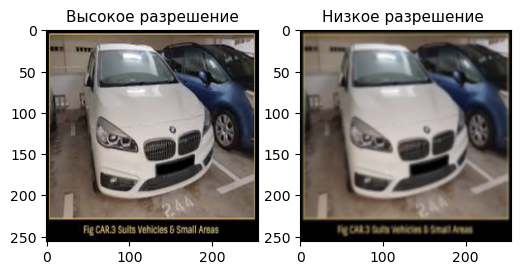

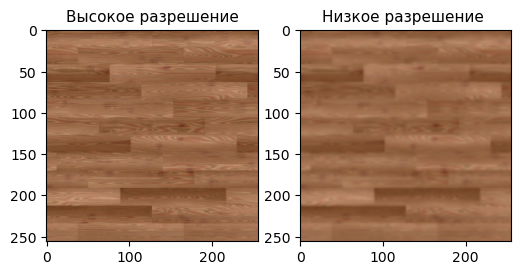

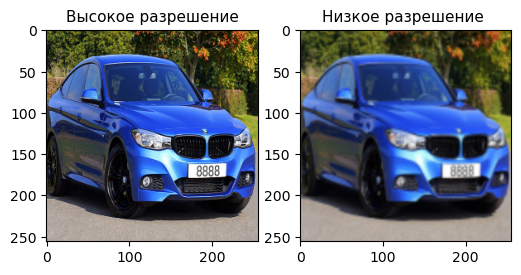

In [13]:
for i in range(3):
    # берем случайное изображение     
    a = np.random.randint(0,855)
    # определяем размер каждой фигуры
    plt.figure(figsize=(6,6))
    # положение фигуры
    plt.subplot(1,2,1)
    # заголовок фигуры
    plt.title('Высокое разрешение', fontsize = 11)
    # вывод на экран
    plt.imshow(high_img[a])
    plt.subplot(1,2,2)
    plt.title('Низкое разрешение ', fontsize = 11)
    plt.imshow(low_img[a])

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))

test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


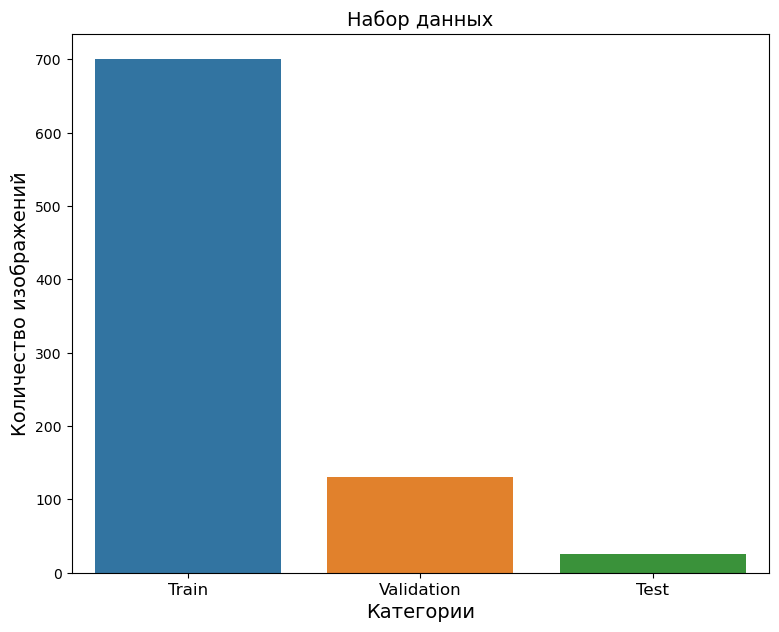

In [38]:
plt.figure(figsize=(9,7))
sns.barplot(x=[0, 1, 2], y=[train_high_image.shape[0], validation_high_image.shape[0], test_high_image.shape[0]])
plt.title('Набор данных', fontsize=14)
plt.xlabel('Категории', fontsize=14)
plt.ylabel('Количество изображений', fontsize=14)
plt.xticks(range(3), ['Train', 'Validation', 'Test'], fontsize=12)
plt.show()

In [6]:
def down(filters, kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape=[SIZE,SIZE,3])
    
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)

    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    
    return tf.keras.Model(inputs=inputs, outputs=output)

In [7]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  147584      ['sequential[0][0]']             
                                                                                              

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [56]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [57]:
model.fit(train_low_image, train_high_image, epochs = 50, batch_size = 5,
          validation_data = (validation_low_image,validation_high_image), callbacks=[early_stopping])

Epoch 1/5
700/700 [==============================] - 18s 25ms/step - loss: 0.0445 - acc: 0.6769 - val_loss: 0.0308 - val_acc: 0.6936
Epoch 2/5
700/700 [==============================] - 16s 23ms/step - loss: 0.0274 - acc: 0.7707 - val_loss: 0.0229 - val_acc: 0.8656
Epoch 3/5
700/700 [==============================] - 18s 25ms/step - loss: 0.0234 - acc: 0.7993 - val_loss: 0.0209 - val_acc: 0.8262
Epoch 4/5
700/700 [==============================] - 17s 25ms/step - loss: 0.0214 - acc: 0.8101 - val_loss: 0.0206 - val_acc: 0.7821
Epoch 5/5
700/700 [==============================] - 19s 27ms/step - loss: 0.0208 - acc: 0.8098 - val_loss: 0.0250 - val_acc: 0.6695


In [58]:
model.save("final_model.h5")

In [9]:
model = load_model("final_model.h5")

1/1 [==============================] - 6s 6s/step


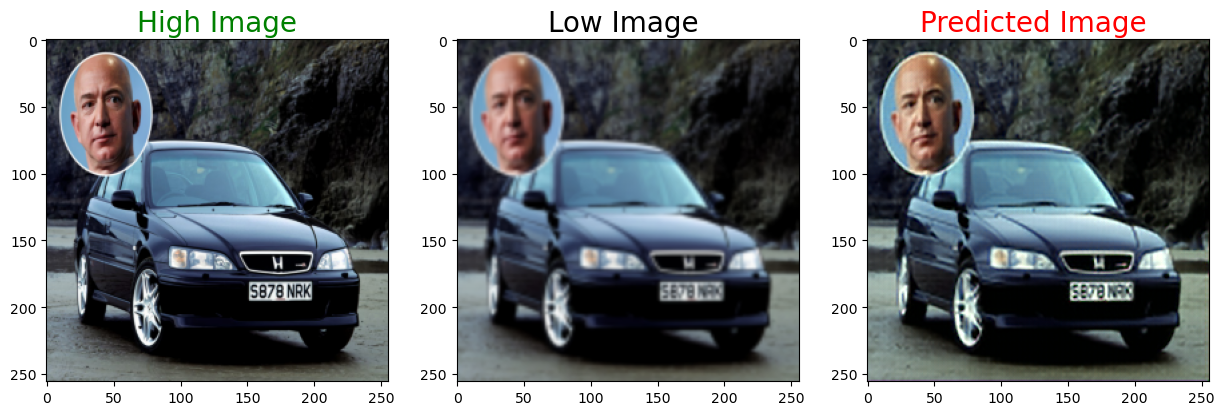

1/1 [==============================] - 0s 18ms/step


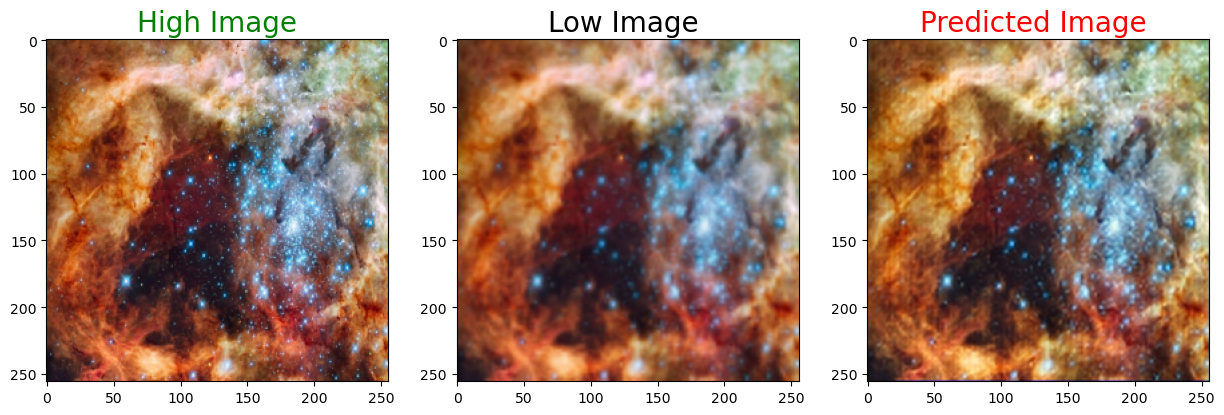

1/1 [==============================] - 0s 15ms/step


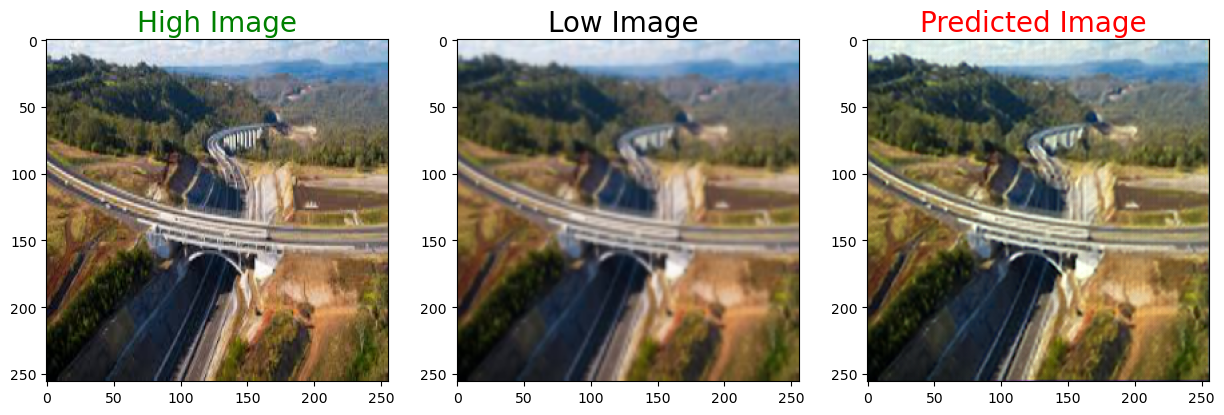

1/1 [==============================] - 0s 34ms/step


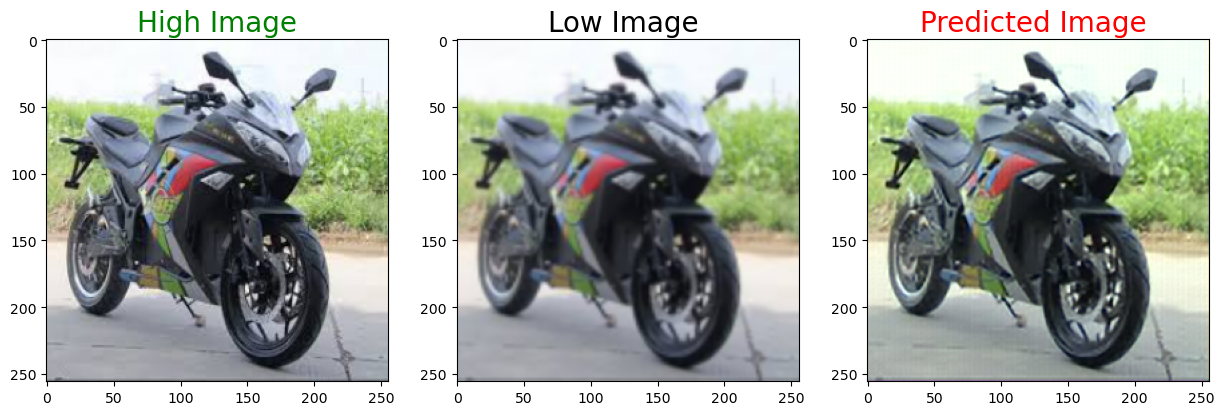

1/1 [==============================] - 0s 15ms/step


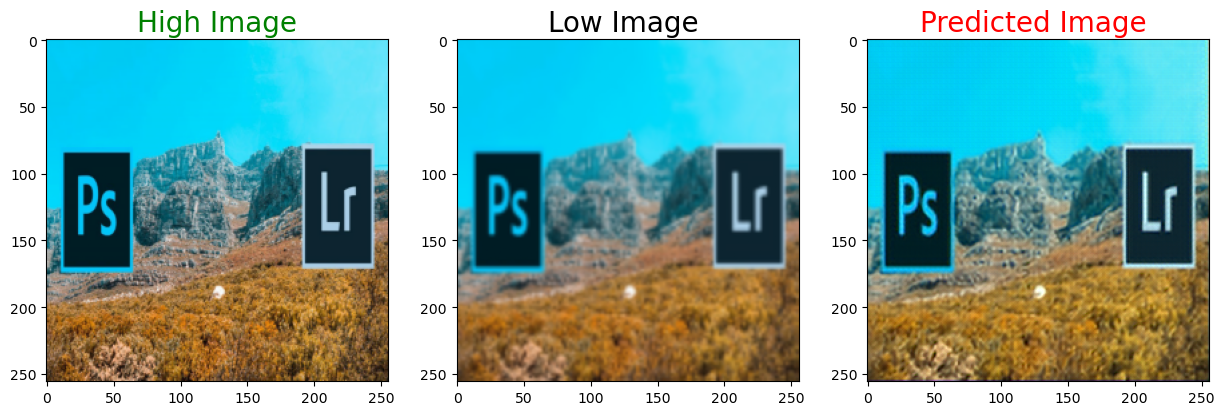

1/1 [==============================] - 0s 20ms/step


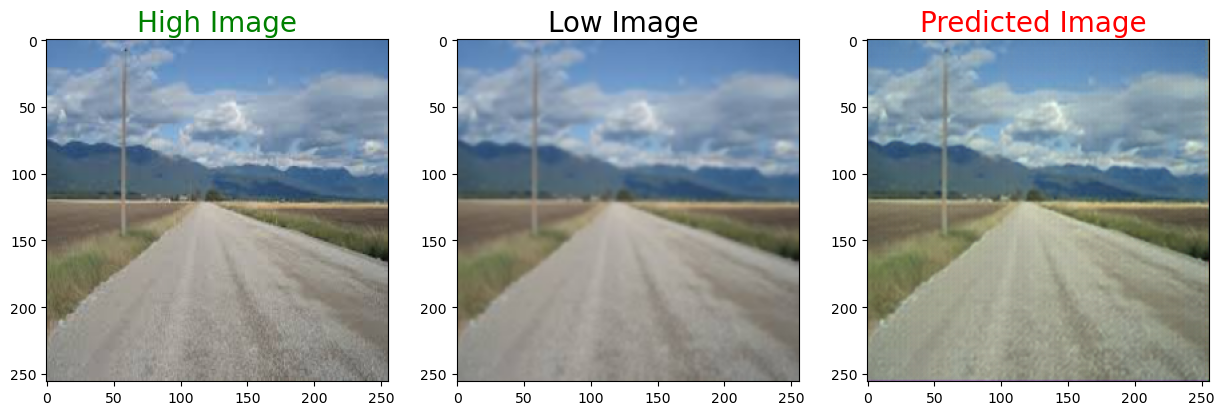

1/1 [==============================] - 0s 16ms/step


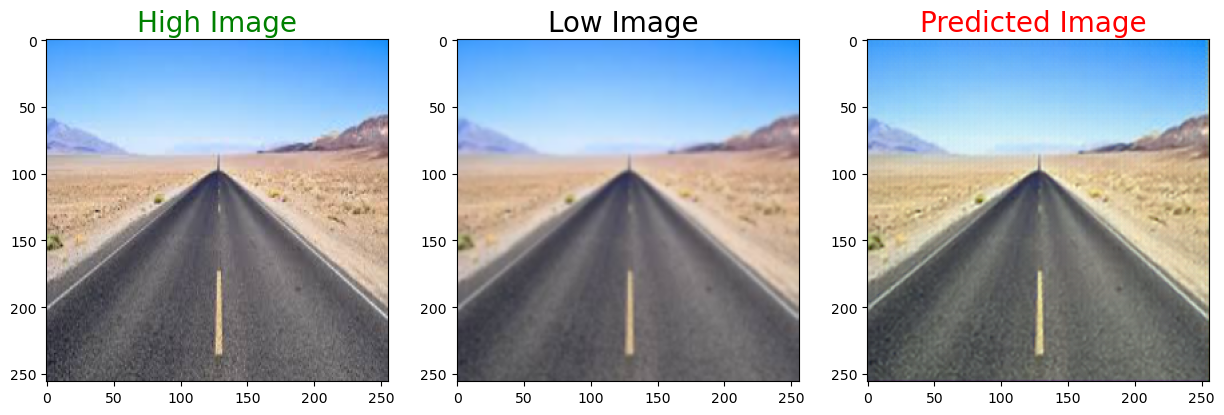

1/1 [==============================] - 0s 33ms/step


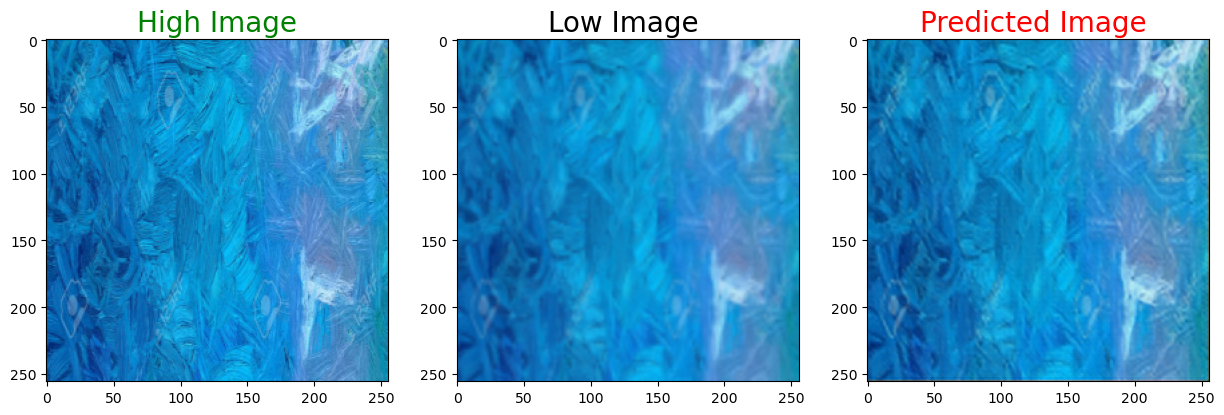

1/1 [==============================] - 0s 16ms/step


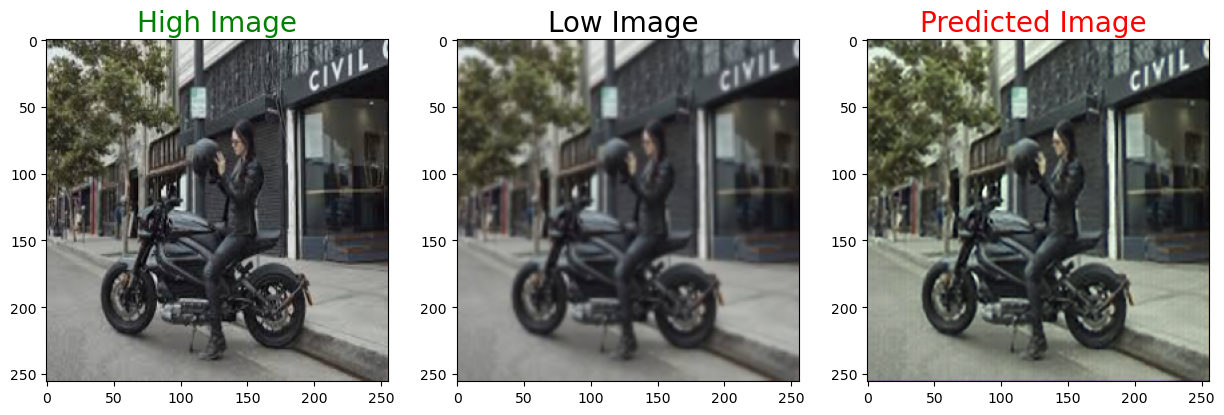

In [10]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    file_name = 'predicted_{}.jpg'.format(i)
    cv2.imwrite(file_name, cv2.cvtColor(predicted*255, cv2.COLOR_BGR2RGB))
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [3]:
model = load_model(r'final_model.h5')

In [14]:
def single_predict(path, save=False):
    # Функция для печати изображения
    def plot_for_single(low,predicted):
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.title('Low Image ', color = 'black', fontsize = 20)
        plt.imshow(low)
        plt.subplot(1,2,2)
        plt.title('Predicted', color = 'green', fontsize = 20)
        plt.imshow(predicted)
        plt.show()

    # Считываем и подготавливаем изображение    
    SIZE = 256
    img = cv2.imread(path,1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0

    # Нормализуем цвета и используем predict
    predicted = np.clip(model.predict(img.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)

    # Печатаем изображение
    plot_for_single(img, predicted)
    
    # Сохраняем, если нужно
    if save:
        file_name = 'predicted.jpg'
        cv2.imwrite(file_name, cv2.cvtColor(predicted*255, cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 21ms/step


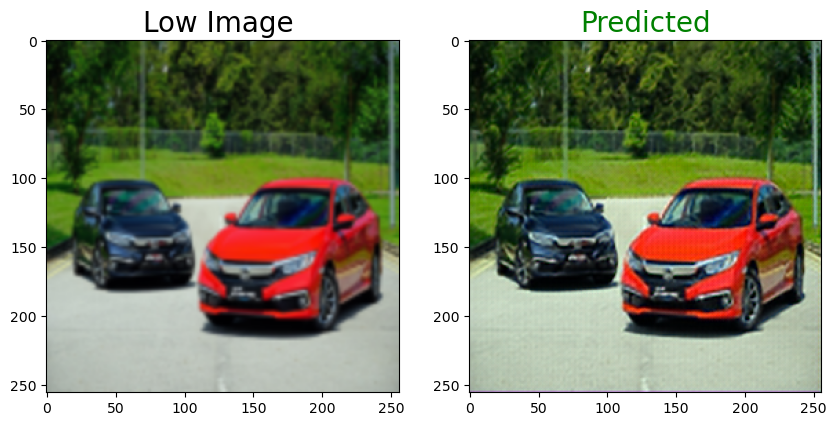

In [15]:
single_predict('0.png', 1)